## 1.기본 package 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir('/content/drive/MyDrive/workspace/당뇨병 예측 보고서')

In [ ]:
## 1.기본
import numpy as np  # numpy 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기
import seaborn as sns
import pandas as pd

## 2.데이터 전처리
from sklearn.preprocessing import StandardScaler # 연속변수의 표준화
from sklearn.preprocessing import LabelEncoder # 범주형변수 수치화

## 3. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split 

## 4.분류모델 - 의사결정트리
from sklearn.tree import DecisionTreeClassifier # 결정 트리

## 5.모델검정
from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # 모델 평가지표
from sklearn.metrics import roc_curve, auc # ROC 곡선

## 6.최적화
from sklearn.model_selection import cross_validate # 교차타당도
from sklearn.pipeline import make_pipeline # 파이프라인 구축
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV # 하이퍼파라미터 튜닝

## 2.데이터 가져오기

### 2.1 데이터프레임으로 저장
- 원본데이터(csv)를 dataframe 형태로 가져오기(pandas)

In [ ]:
dia_df = pd.read_csv('data.csv', encoding='euc-kr')
dia_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,glu_ins
0,6,148.0,72.0,35.0,206.846154,33.6,0.627,50,1,고위험군
1,1,85.0,66.0,29.0,130.287879,26.6,0.351,31,0,저위험군
2,8,183.0,64.0,33.0,206.846154,23.3,0.672,32,1,고위험군
3,1,89.0,66.0,23.0,94.000000,28.1,0.167,21,0,저위험군
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,1,저위험군


<pre>
Pregnancies : 임신횟수
Glucose : 포도당수치
BloodPressure : 혈압
SkinThickness : 피하지방
Insulin : 인슐린
BMI : 체질량지수
DiabetesPedigreeFunction : 당뇨 내력 가중치 값
Age : 나이
Outcome : 당뇨여부 1(당뇨) / 0(정상)
</pre>

- 자료구조 살펴보기

In [ ]:
dia_df.shape

(768, 10)

In [ ]:
# 자료구조 살펴보기
dia_df.keys()

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'glu_ins'],
      dtype='object')

In [ ]:
# sns.pairplot(dia_df, hue='Outcome')

### 2.2 data와 target으로 분리
- data: X, target: y 로 분리

In [ ]:
y = dia_df['Outcome']
X = dia_df.drop ('Outcome', axis=1)

X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,glu_ins
0,6,148.0,72.0,35.0,206.846154,33.6,0.627,50,고위험군
1,1,85.0,66.0,29.0,130.287879,26.6,0.351,31,저위험군
2,8,183.0,64.0,33.0,206.846154,23.3,0.672,32,고위험군
3,1,89.0,66.0,23.0,94.000000,28.1,0.167,21,저위험군
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,저위험군


## 3.데이터 전처리

In [ ]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'glu_ins'],
      dtype='object')

In [ ]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,3.845052,121.697358,72.428141,29.247042,157.003527,32.44642,0.471876,33.240885
std,3.369578,30.462008,12.106044,8.923908,88.860914,6.87897,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.20000,0.078000,21.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.50000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,28.000000,130.287879,32.05000,0.372500,29.000000
75%,6.000000,141.000000,80.000000,33.000000,206.846154,36.60000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.10000,2.420000,81.000000


### 3.1 라벨 인코딩

In [ ]:
encoder = LabelEncoder()
X['glu_ins'] = encoder.fit_transform(X['glu_ins'])
X['glu_ins'].head()

0    0
1    1
2    0
3    1
4    1
Name: glu_ins, dtype: int64

### 3.2 스케일링

In [ ]:
X_num = X[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']] # 수치형 변수
X_cat = X['glu_ins'] # 범주형 변수

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, index=X_num.index, columns=X_num.columns)

X = pd.concat([X_scaled, X_cat], axis=1)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,glu_ins
0,0.639947,0.864020,-0.035389,0.645088,0.561272,0.167806,0.468492,1.425995,0
1,-0.844885,-1.205478,-0.531332,-0.027701,-0.300842,-0.850452,-0.365061,-0.190672,1
2,1.233880,2.013741,-0.696647,0.420825,0.561272,-1.330487,0.604397,-0.105584,0
3,-0.844885,-1.074081,-0.531332,-0.700491,-0.709475,-0.632253,-0.920763,-1.041549,1
4,-1.141852,0.502679,-2.680419,0.645088,0.123830,1.549727,5.484909,-0.020496,1


## 4.훈련/검증용 데이터 분할
- test_size: 검증데이터 30%
- random_state : random seed 번호 = 1
- stratify : y(클래스)의 비율에 따라 분할

In [ ]:
# \ 이후에 space 없어야 함
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, 
                         test_size=0.3, 
                         random_state=1, 
                         stratify=y)

## 5.모델구축

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=None,
                              random_state=1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

## 6. 모델검정

### 6.1 검증용 데이터로 예측
- predict (class로 표시)
- predict_proba (확률값으로 표시)

In [ ]:
y_pred = tree.predict(X_test)

### 6.2 정오분류표로 검정

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],132,18
True[1],18,63


In [ ]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       150
           1       0.78      0.78      0.78        81

    accuracy                           0.84       231
   macro avg       0.83      0.83      0.83       231
weighted avg       0.84      0.84      0.84       231



### 6.3 정확도, 민감도 확인
- 클래스가 2개일 경우에만 실행

In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 36
정확도: 0.844
정밀도: 0.778
재현율: 0.778
F1: 0.778


### 6.4 ROC 곡선 그리기
- decision_function 사용가능한 모델일 경우: tree.decision_function(X_test)
- decision_function 사용이 안되는 모델일 경우:tree.predict_proba(X_test)[:, 1]

In [ ]:
# fpr, tpr, thresholds = roc_curve(y_test, tree.decision_function(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:, 1])

In [ ]:
fpr, tpr, thresholds

(array([0.  , 0.12, 1.  ]),
 array([0.        , 0.77777778, 1.        ]),
 array([2., 1., 0.]))

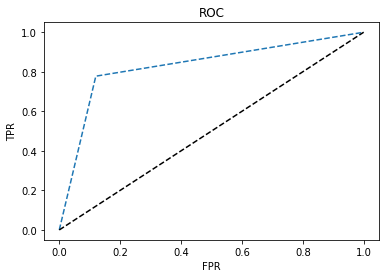

In [ ]:
plt.plot(fpr, tpr, '--', label="Decision Tree")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fpr], [tpr], 'r-', ms=10)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image #CART Tree 그림 
import pydotplus
import os

- export_graphviz 설치 폴더를 인식시켜주어야 함
- (중요)아래와 같이 \ 로 표시되면 에러가 발생함
- os.environ['PATH'] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin\'
- \ --> /

In [ ]:
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [ ]:
feature_names = X.columns.tolist()
target_name = np.array(['No', 'Yes'])

In [ ]:
dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=target_name,
                           feature_names=feature_names,
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

True

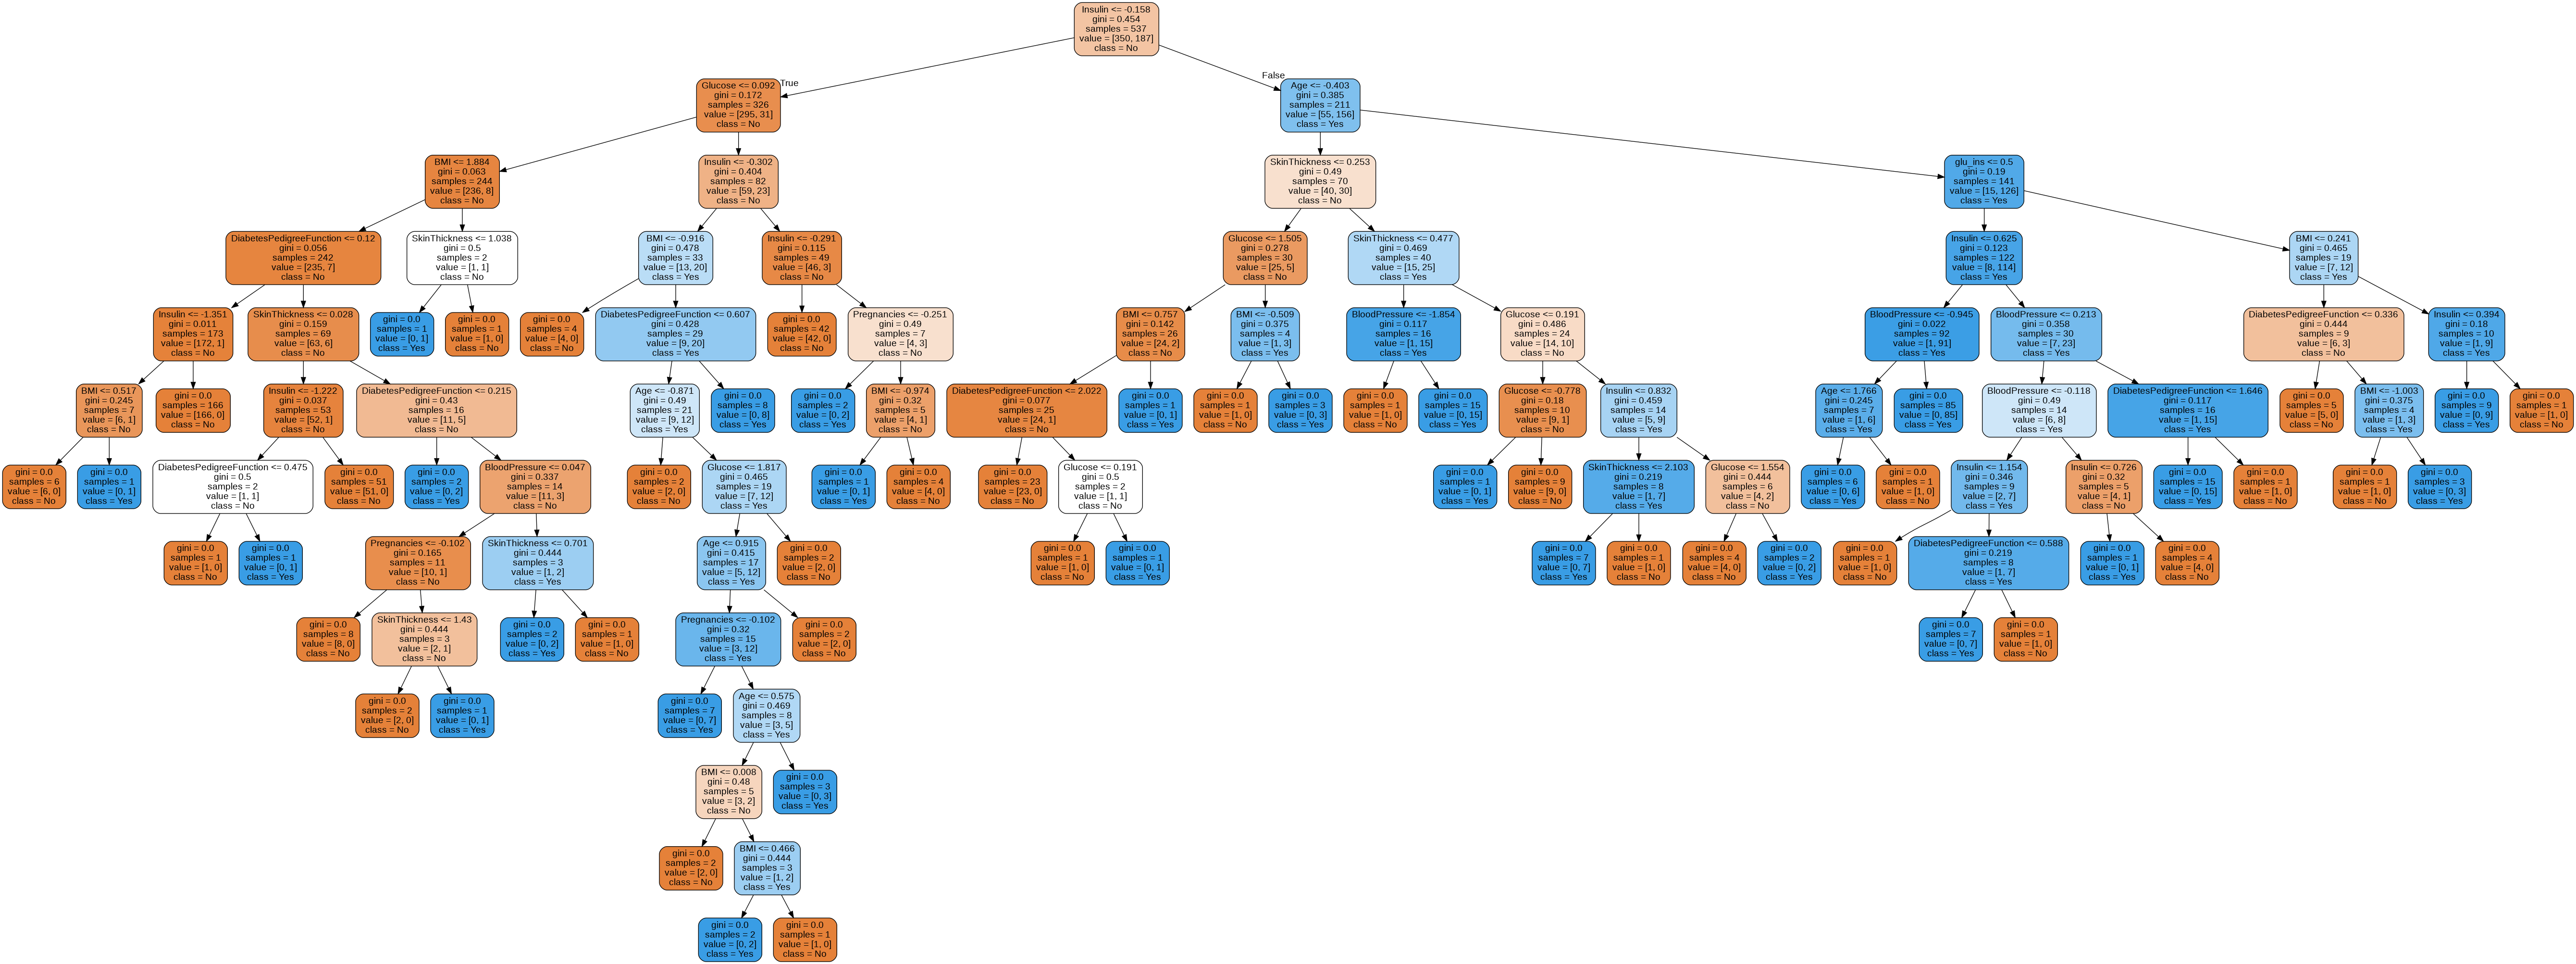

In [ ]:
dt_graph = pydotplus.graph_from_dot_data(dot_data)
Image(dt_graph.create_png())

# 최적화

### 7.1 교차검정

In [ ]:
scores = cross_validate(estimator=tree, 
                        X=X_train, 
                        y=y_train, 
                        scoring=['accuracy'], 
                        cv=10, 
                        n_jobs=-1,
                        return_train_score=False)
print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), 
                                 np.std(scores['test_accuracy'])))

CV 정확도 점수: [0.85185185 0.83333333 0.85185185 0.90740741 0.77777778 0.81481481
 0.7962963  0.88679245 0.81132075 0.90566038]
CV 정확도: 0.844 +/- 0.043


### 7.2 파이프라인 모델 만들기
- 파이프라인을 이용하여 최적 모델 만들기
- 기본모형은 아무 옵션이 없는 모델로 부터 시작
- 파라미터 옵션 확인: pipe_tree.get_params().keys()

In [ ]:
pipe_tree = make_pipeline(DecisionTreeClassifier())

In [ ]:
pipe_tree.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'decisiontreeclassifier', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_impurity_split', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__presort', 'decisiontreeclassifier__random_state', 'decisiontreeclassifier__splitter'])

### 7.3 학습 곡선으로 편향과 분산 문제 분석하기
- 훈렴 샘플링 수를 이용하여 편향과 분산 검정
- 편향: 정확도가 높은지 검정
- 분산: 훈련/검정 데이터의 정확도의 차이가 적은지

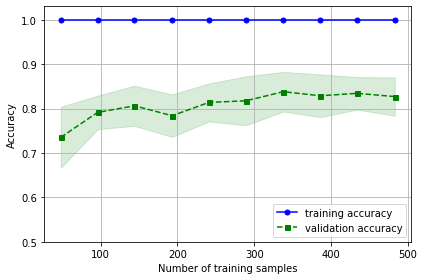

In [ ]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_tree, # 수정
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.03])  # 수정
plt.tight_layout()
plt.show()

### 7.4 검증 곡선으로 과대적합과 과소적합 조사하기
- 과대적합 : 파라미터가 많음 -> 파라미터 축소
- 과소적합 : 파라미터가 적음 -> 파라미터 추가

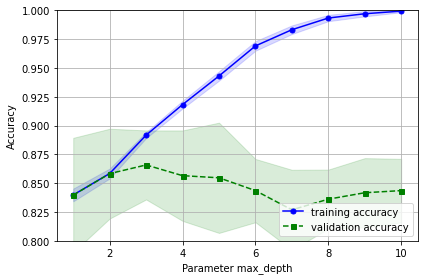

In [ ]:
param_range = [1,2,3,4,5,6,7,8,9,10]  # 수정
train_scores, test_scores = validation_curve(
                estimator=pipe_tree, # 수정
                X=X_train, 
                y=y_train, 
                param_name='decisiontreeclassifier__max_depth', ## 수정
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of max_depth') # 수정
plt.legend(loc='lower right')
plt.xlabel('Parameter max_depth') # 수정
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.00])  # 수정
plt.tight_layout()
plt.show()

### 7.5 하이퍼파라미터 튜닝
- 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝
- 기계학습 모델의 성능을 결정하는 하이퍼 파라미터 튜닝

In [ ]:
param_range1 = [1,2,3,4,5,6,7,8,9,10] 
param_range2 = [10,20,30,40,50]

param_grid = [{'decisiontreeclassifier__max_depth': param_range1, 
               'decisiontreeclassifier__min_samples_leaf': param_range2}] 

gs = GridSearchCV(estimator=pipe_tree, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.878825995807128
{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__min_samples_leaf': 30}


## 8.최적화 모델 검정
- 최적모델을 이용해 검정 데이터(full data) 최종 확인
- best_tree 로 모델명 변경

In [ ]:
best_tree = gs.best_estimator_
best_tree.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=3,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=30,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

- 검증용 데이터로 예측

In [ ]:
y_pred = best_tree.predict(X_test) 

- 정오분류표로 검정

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],129,21
True[1],10,71


In [ ]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       150
           1       0.77      0.88      0.82        81

    accuracy                           0.87       231
   macro avg       0.85      0.87      0.86       231
weighted avg       0.87      0.87      0.87       231



- 정확도, 민감도 확인

In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 31
정확도: 0.866
정밀도: 0.772
재현율: 0.877
F1: 0.821


- ROC 곡선 그리기

In [ ]:
from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(y_test, best_tree.decision_function(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_tree.predict_proba(X_test)[:, 1])

In [ ]:
fpr, tpr, thresholds

(array([0.        , 0.03333333, 0.06      , 0.08666667, 0.14      ,
        0.2       , 0.38      , 0.49333333, 1.        ]),
 array([0.        , 0.51851852, 0.59259259, 0.80246914, 0.87654321,
        0.91358025, 0.9382716 , 0.95061728, 1.        ]),
 array([1.93518519, 0.93518519, 0.75757576, 0.625     , 0.60606061,
        0.16666667, 0.09859155, 0.06122449, 0.00578035]))

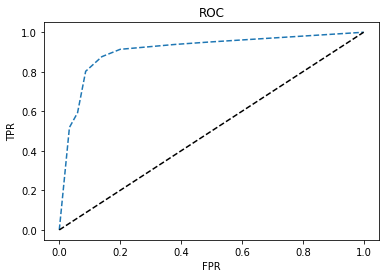

In [ ]:
plt.plot(fpr, tpr, '--', label="Decision Tree")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fpr], [tpr], 'r-', ms=10)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=6,
                              min_samples_leaf=10,     
                              random_state=1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [ ]:
dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=target_name,
                           feature_names=feature_names,
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

True

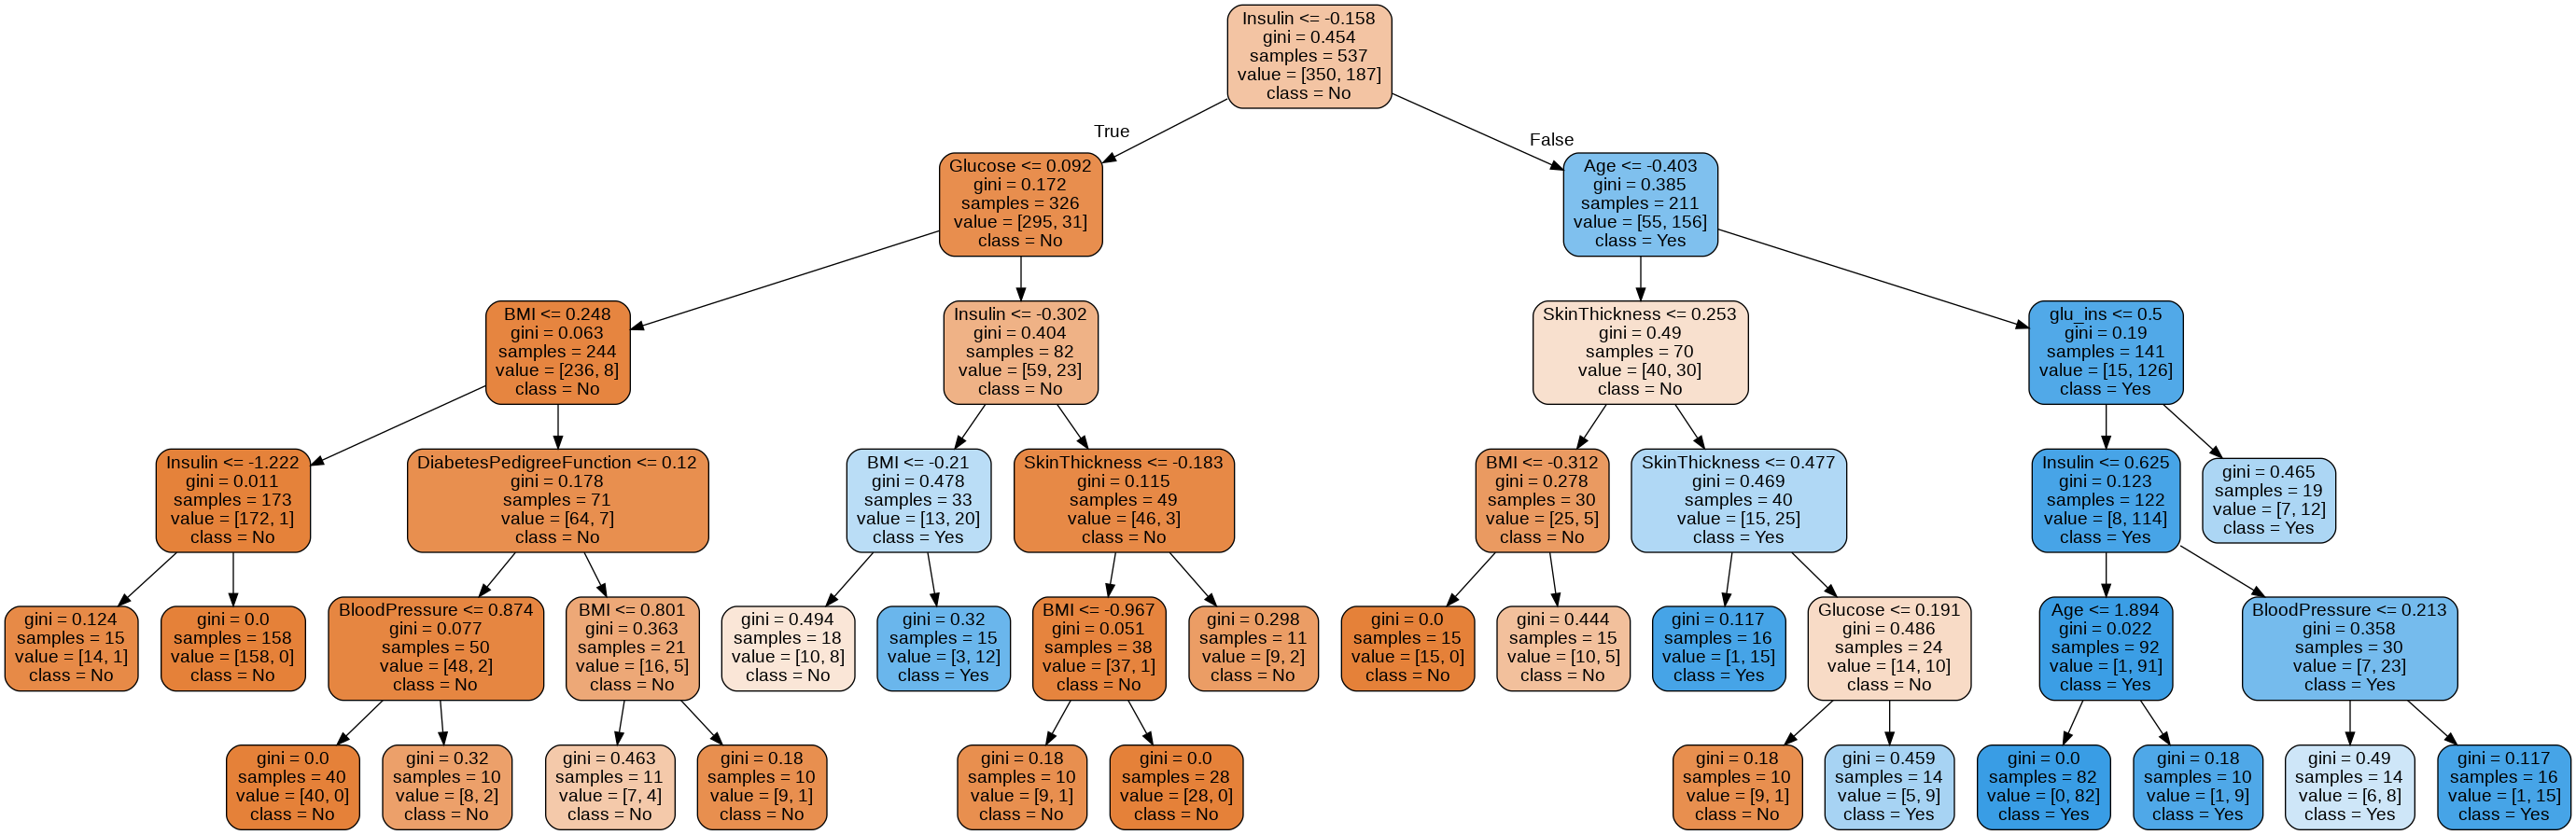

In [ ]:
dt_graph = pydotplus.graph_from_dot_data(dot_data)
Image(dt_graph.create_png())